In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from math import exp

In [3]:
def get_activity_data(dataset, activity):
    read_path = r'..\CASAS_DATA' + '\HH' + dataset + '\Activities' + '\\' + activity + '.csv'
  
    df = pd.read_csv(read_path)
    start = list(df['Start_Time'])
    dur = list(df['Duration'])
    return start, dur

In [4]:
def processData(df):
    data = df[['Start_Time', 'Duration']]
    data = data.values.astype('float32', copy=False)
    return data

def scaleData(data):
    scaler = StandardScaler().fit(data)
    scaled_data = scaler.transform(data)
    return scaled_data

def dbscan(df, r, mp):
    data = processData(df)
    X = scaleData(data)
    model = OPTICS(min_samples=r, min_cluster_size=mp).fit(X)
    #model = DBSCAN(eps=r, min_samples=mp, metric='euclidean').fit(X)

    if -1 in set(model.labels_):
        clusters = len(set(model.labels_)) -1
    else:
        clusters = len(set(model.labels_))


    A = []
    for i in range(clusters):
        a = data[model.labels_ == i]
        A.append(a)
    return A

In [5]:

def avg(A):
    a = sum(A)/len(A)
    a = float('%.2f'%a)
    return a

def Min(A):
    a = min(A)
    a = float('%.2f'%a)
    return a

def Max(A):
    a = max(A)
    a = float('%.2f'%a)
    return a

In [6]:
def by_datasets(Datasets, activity):

    Start = []
    Duration = []

    for dataset in Datasets:
        
        s, d = get_activity_data(dataset, activity)
        Start.extend(s)
        Duration.extend(d)
    
    data = pd.DataFrame({
        'Start_Time': Start,
        'Duration': Duration
    })
    
    return data

def toStartDuration(A):
    X = []
    Y = []
    for i in range(len(A)):
        X.append(A[i][0])
        Y.append(A[i][1])

    return X, Y
   
def plot_clusters(C, title='None'):
    colors = ['red', 'orange', 'purple', 'green', 'blue', 'black']
    c = 0
    fig = plt.figure()
    plt.title(title)
    for c in C:
        X, Y = toStartDuration(c)
        plt.scatter(X, Y)
        c += 1
    
        
def cluster_to_list(C, activity):
    Normal = []
    x = 1
    for c in C:
        S, D = toStartDuration(c)
        label = activity + str(x)
        avgS = avg(S)
        avgD = avg(D)
        minS = Min(S)
        maxS = Max(S)
        minD = Min(D)
        maxD = Max(D)
        
        Normal.append([activity, label, avgS, avgD, minS, maxS, minD, maxD])
        x += 1
    return Normal
    

In [20]:
Duration_Weight = {
    'Eat':2,
    'Sleep':2,
    'Medicine': 0
}
Start_Weight = {
    'Medicine': 3,
    'Eat':2,
    'Sleep':2,
}

C = 10**10

def sec(s):
    h, m, s = map(int, s.split(':'))
    return h*3600 + m*60 + s

def fitS(x1, x2, act):
    x = abs(x2-x1)
    n = 4
    b = 3500
    C = 30
    
    score = C*exp(-(x/b)**n)
    score = score*Start_Weight[act]
    return score
    
def fitD(x1, x2,  act):
    Width = {'Sleep':2, 'Medicine': 1, 'Eat': 1, 'Bathe': 0.8}
    
    x = abs(x2-x1)
    n = 4
    b = 1000*Width[act]
    C = 30
    
    score = C*exp(-(x/b)**n)
    score = score*Duration_Weight[act]
    return score

eat = ['Eat', 'Eat_Breakfast', 'Eat_Lunch', 'Eat_Dinner']
sleep = ['Sleep']
med = ['Morning_Meds', 'Evening_Meds']
A = {'Eat': eat,  'Sleep': sleep, 'Medicine': med}

def fitness_day(normal, day, d):
    Score = 0
    
    for act in A:
        day_act = day[day['Activity'].isin(A[act])] 
        normal_act = normal[normal['Activity'] == act]
     
        score = fitness_activity(normal_act, day_act, act)
        Score += score
    return Score

def fitness_activity(normal, day, act):

    Score = 0
    n = len(normal)
    m = len(day)
    
    for i in range(n):
        maxx = 0
        for j in range(m):
            row1 = normal.iloc[i]
            row2 = day.iloc[j]
            
            score = fitness(row1, row2, act)
            maxx = max(maxx, score)
        Score += maxx
        
    return Score
        
def fitness(row1, row2, act):
    normal_start = row1['Start']*60*60
    normal_duration = row1['Duration']*60
    
    day_start = sec(row2['Start'])
    day_finish = sec(row2['Finish'])
    day_duration = day_finish - day_start
    
    score = 0
    score += fitD(normal_duration, day_duration, act)
    score += fitS(normal_start, day_start, act)

    return score

In [21]:
def train_datasets(Datasets):
    multiplier = len(Datasets)
    
    Activities = ['Sleep', 'Medicine', 'Eat']
    radius = {'Sleep': 2, 'Eat': 4, 'Medicine': 6}
    min_pts =  {'Sleep': 15*multiplier, 'Eat': 18*multiplier, 'Medicine': 20*multiplier}
    Normal = []
    for activity in Activities:
        data = by_datasets(Datasets, activity)
        clusters = dbscan(data, radius[activity], min_pts[activity])
        plot_clusters(clusters, activity)
        normal = cluster_to_list(clusters, activity)
        Normal.extend(normal)
    Normal_df = pd.DataFrame(Normal, columns=['Activity', 'Cluster', 'Start', 'Duration', 'Min_Start', 'Max_Start','Min_Dur', 'Max_Dur'])
   
    return Normal_df

In [22]:
def get_fitness_plot(trained_dataset, test, trained):
    #trained_dataset = pd.read_csv(r'D:\Daily Life Anomaly Detection\CASAS_DATA\\' + trained + r'\Activities\Clusters\Normal.csv')
    
    count = 1
    Fitness_Days = []
    Fitness_Score = []
    change = []
    
    for dataset in test:
        Day_start = 1
        dirc = r'..\CASAS_DATA' + '\HH' + dataset + r'\cleaned'
        Day_end = len(os.listdir(dirc))

        for day in range(Day_start, Day_end):
            read_path = r'..\CASAS_DATA' + '\HH' + dataset + r'\cleaned\Day' + str(day) + r'.csv'

            day_df = pd.read_csv(read_path)
            fitness_score = fitness_day(trained_dataset, day_df, day)
            fs = float('%.1f'%fitness_score)
            
            Fitness_Days.append(count)
            count += 1
            Fitness_Score.append(fs)
           
        change.append(count)
    
    fig = plt.figure(figsize=(15,8))
    plt.plot(Fitness_Days, Fitness_Score, marker = 'o', mfc = 'r')
    title = trained + ' Trained  | ' + ' Testing on ' + ', '.join(test)
    plt.title(title,fontdict = {'fontsize' : 20})
    plt.xlabel('Days',fontdict = {'fontsize' : 13})
    plt.ylabel('Fitness Score', fontdict = {'fontsize' : 13})
    
    for c in change:
        plt.plot([c,c], [0, 500], color='orange', linestyle='--', linewidth=2)
    

In [23]:
def save_df(df, s):
    savepath = r'..\CASAS_DATA\K-FOLD' + '\\' + s + '.csv'
    df.to_csv(savepath, index = False)
     

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


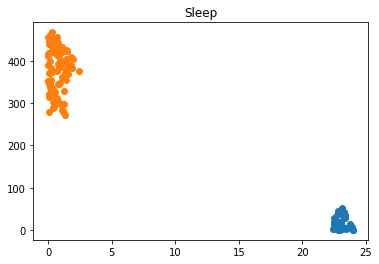

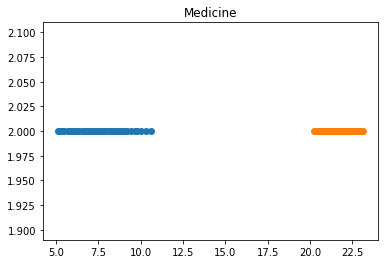

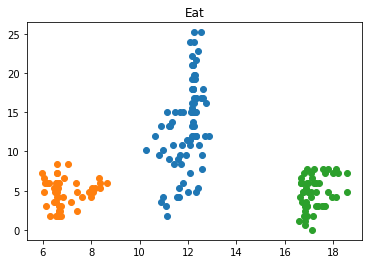

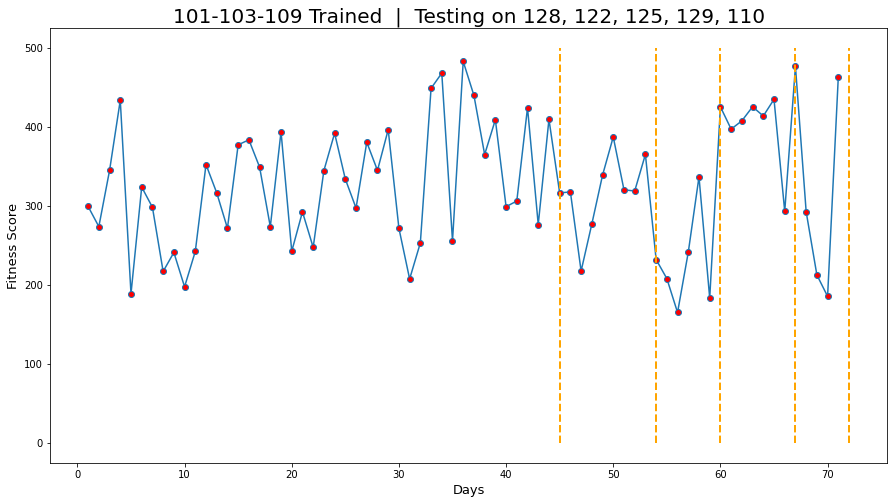

In [24]:
train_dataset = ['101', '103', '109']
train_str = '-'.join(train_dataset)
train_df = train_datasets(train_dataset)
save_df(train_df, train_str)
get_fitness_plot(train_df, ['128','122', '125','129', '110'], train_str)

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


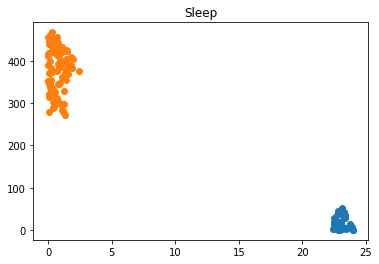

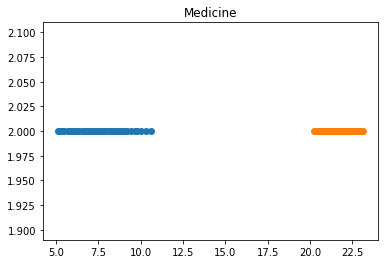

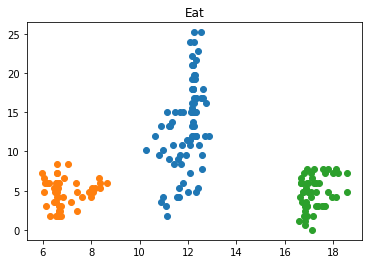

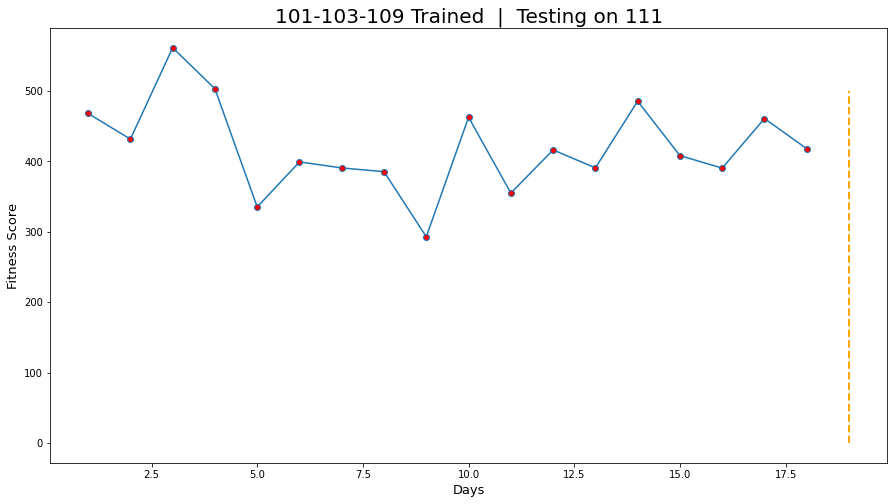

In [27]:
train_dataset = ['101', '103', '109']
train_str = '-'.join(train_dataset)
train_df = train_datasets(train_dataset)
save_df(train_df, train_str)
get_fitness_plot(train_df, ['111'], train_str)

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


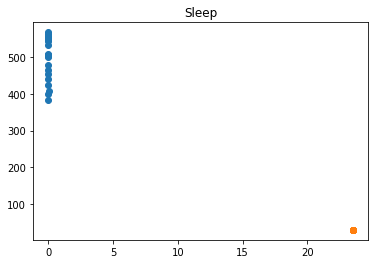

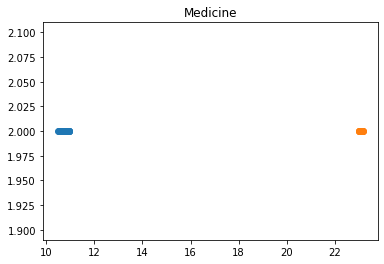

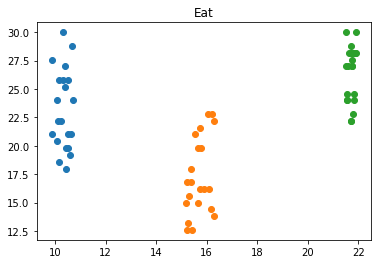

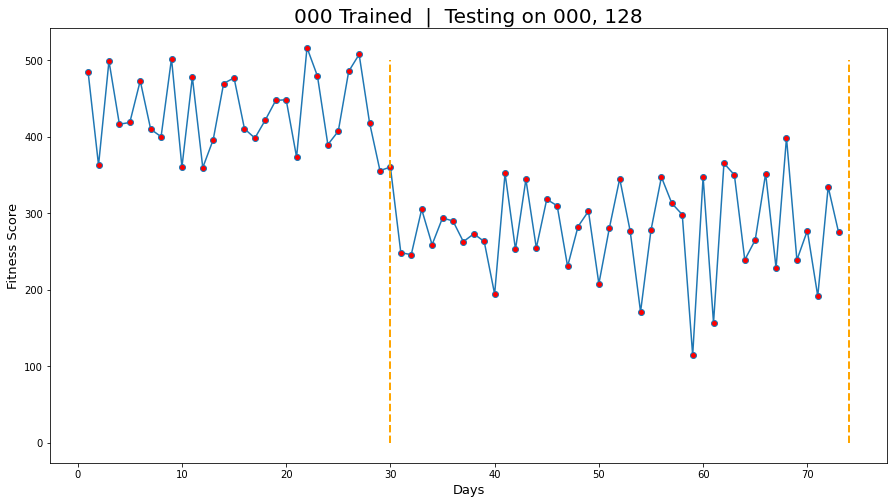

In [26]:
train_dataset = ['000']
train_str = '-'.join(train_dataset)
train_df = train_datasets(train_dataset)
save_df(train_df, train_str)
get_fitness_plot(train_df, ['000', '128'], train_str)

In [51]:
train_df

,Activity,Cluster,Start,Duration,Min_Start,Max_Start,Min_Dur,Max_Dur
0,Sleep,Sleep1,1.00,454.80,1.00,1.02,371.2,511.0
1,Sleep,Sleep2,24.50,29.80,24.50,24.50,29.8,29.8
2,Medicine,Medicine1,11.77,3.00,11.50,11.98,3.0,3.0
3,Medicine,Medicine2,24.11,3.00,24.07,24.15,3.0,3.0
4,Eat,Eat1,11.35,23.86,10.82,11.70,19.0,31.0
5,Eat,Eat2,16.66,16.60,16.17,17.30,13.6,19.0
6,Eat,Eat3,22.72,27.16,22.52,22.95,23.2,31.0
